<a href="https://colab.research.google.com/github/lburiti/aprendizado-machine-learning-Python/blob/Deep_Learning/Rede_Neural_do_zero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as pd
import torch
import torch.nn.functional as nf
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [2]:
transform = transforms.ToTensor()

trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

valset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



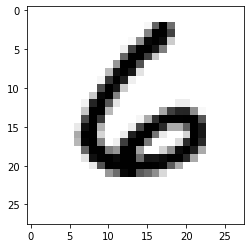

In [3]:
dataiter = iter(trainloader)
imagens, etiquetas = dataiter.next()
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r');

In [10]:
print(imagens[0].shape) # verificar dimensões do tensor de cada imagem
print(etiquetas[0].shape) # verificar dimensões do tensor de cada etiqueta

torch.Size([1, 28, 28])
torch.Size([])


In [15]:
from torch.nn.modules.upsampling import F
class Modelo(nn.Module):
    def __init__(self):
      super(Modelo, self).__init__()
      self.linear1 = nn.linear(28*28, 128) # camada de entrada, 784 neurônios que se ligam a 128
      self.linear2 = nn.linear(128, 64) # camada interna 1, 128 neurônios que se ligam a 64
      self.linear3 = nn.linear(64, 10) # camada interna 2, 64 neurônios que se ligam a 10
    # para a camada de saída não é necessário definir nada pois só precisamos pegar o output da camada interna 2

    def forward(self,X):
      X = F.relu(self.linear1(X)) # função de ativação da camada de entrada para a camada interna 1
      X = F.relu(self.linear2(X))  # função de ativação da camada de entrada para a camada interna 2
      X = self.linear3(X)  # função de ativação da camada interna 2 para a camada de saída, nesse caso f(x) = x
      return F.log_softmax(X, dim=1) # dados utilizados para calculas a perda

In [16]:
def treino (modelo, trainloader, device):

  otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5) # define a politica de atualização dos pesos e da bias
  inicio = time() # timer para saber quanto tempo levou o treino

  criterio = nn.NLLLoss() # definindo o criterio para calcular a perda
  EPOCHS = 10 # numero de epochs que o algoritmo rodará
  modelo.train()

  for epoch in range(EPOCHS):
    perda_acumulada = 0 # inicialização da perda acumulada da epoch em questão

    for imagens, etiquetas in trainloader:

        imagens = imagens.view(imagens.shape[0], -1) # convertendo as imagens para vetores de 28*28....
        otimizador.zero_grad() # zerando os gradientes por conta do ciclo anterior

        output = modelo(imagens.to(device)) # colocando os dados no modelo
        perda_instantanea = criterio(output, etiquetas.to(device)) # calculando a perda da epoch em questão

        perda_instantanea.backward() # back propagation a partir da perda

        otimizador.step() # atualizando os pesos e a bias

        perda_acumulada += perda_instantanea.item() #atualização da perda acumulada

    else:
          print("Epoch {} - Perda resultante: {}".format(epoch+1, perda_acumulada/len(trainloader)))
    print("\nTempo de treino (em minutos) = ",(time()-inicio)/60)

In [17]:
def validacao(modelo, valloader, device):
    conta_corretas, conta_todas = 0, 0
    for imagens, etiquetas in valloader:
      for i in range(len(etiquetas)):
        img = imagens[i].view(1, 784)

        with torch.no_grad():
            logps = modelo(img.to(device))

        
        ps = torch.exp(logps)
        probab = list(ps.cpu().numpy()[0])
        etiqueta_pred = probab.index(max(probab))
        etiqueta_certa = etiquetas.numpy()[i]
        if(etiqueta_certa == etiqueta_pred):
          conta_corretas += 1
        conta_todas +=1

    print("Total de imagens testadas =", conta_todas)
    print("\nPrecisão do modelo = {}%".format(conta_corretas*100/conta_todas))


In [18]:
modelo = Modelo()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo.to(device)

AttributeError: ignored